In [1]:
%load_ext memory_profiler

In [2]:
import json

import numpy as np
import pandas as pd
# import geopandas as gpd
import rioxarray as riox

from pyproj import Transformer
from shapely.geometry import mapping, Point

## show the mean from scaled data and the scaled mean are the same

In [3]:
random_data = np.random.random(100) * 600 + 124
random_data[:5]

array([143.23646358, 378.80978512, 316.9033385 , 655.80381898,
       219.95886609])

In [4]:
scaling = 5
offset = -3

In [5]:
(random_data * scaling + offset).mean()

2134.006662055345

In [6]:
random_data.mean() * scaling + offset

2134.006662055345

__No need to scale the data, but only set the missing value to 0__

## Run the analysis in a scalable way

load the raster and fill NaNs with 0

In [7]:
myraster = (
    riox.open_rasterio('test-data/Impervious_Surface_NOAA_Satellite_2010/Impervious_Surface_NOAA_Satellite_2010/data_provided/impsa_2010_20210519.tif')
    .sel(band=1)
)

In [8]:
myraster = myraster.where(myraster != myraster.rio.nodata, 0)

Load points for data extraction and create buffers

In [9]:
transformer = Transformer.from_crs("EPSG:3577", myraster.rio.crs, always_xy=True)

In [10]:
points = (
    pd.read_csv('test-data/APPMA_test_subset.csv')
    .assign(
        lat_lon_tuple = lambda columns: columns[['x', 'y']].apply(lambda row: transformer.transform(row['x'], row['y']), axis=1),
        lat = lambda columns: columns['lat_lon_tuple'].apply(lambda el: el[0]),
        lon = lambda columns: columns['lat_lon_tuple'].apply(lambda el: el[1]),
        points = lambda columns: columns['lat_lon_tuple'].apply(Point),
        points_buffer = lambda columns: columns['points'].apply(lambda x: x.buffer(10))
    )
)

In [11]:
points.head()

,x,y,lat_lon_tuple,lat,lon,points,points_buffer
0,1.338752e+06,-3.860481e+06,"(146.6897558575884, -34.6523707513246)",146.689756,-34.652371,POINT (146.6897558575884 -34.6523707513246),"POLYGON ((156.6897558575884 -34.6523707513246,..."
1,1.164170e+06,-3.923904e+06,"(144.8577049948836, -35.38806689394188)",144.857705,-35.388067,POINT (144.8577049948836 -35.38806689394188),POLYGON ((154.8577049948836 -35.38806689394188...
2,1.259190e+06,-4.078028e+06,"(146.08603136242695, -36.67940370746854)",146.086031,-36.679404,POINT (146.086031362427 -36.67940370746854),"POLYGON ((156.086031362427 -36.67940370746854,..."
3,1.088017e+06,-3.216140e+06,"(143.33014417830566, -29.148710955228086)",143.330144,-29.148711,POINT (143.3301441783057 -29.14871095522809),POLYGON ((153.3301441783057 -29.14871095522809...
4,1.923990e+06,-4.192711e+06,"(153.62179911184072, -36.86883390213634)",153.621799,-36.868834,POINT (153.6217991118407 -36.86883390213634),POLYGON ((163.6217991118407 -36.86883390213634...


Memory of dataframe in MB

In [12]:
points.memory_usage(deep=True).sum() / 1024**2

0.015380859375

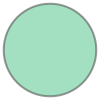

In [13]:
points['points_buffer'][0]

In [14]:
list(points['points_buffer'][0].exterior.coords)[:5]

[(156.6897558575884, -34.6523707513246),
 (156.6416031243104, -35.632542154620204),
 (156.49760866162072, -36.603273971485876),
 (156.2591592149105, -37.55521752386922),
 (155.92855118270128, -38.47920507497549)]

In [15]:
def extract_mean_from_buffer(raster, geom):
    data_points = pd.Series(geom.exterior.coords)
    values_from_raster = data_points.apply(lambda row: raster.sel(x=row[0], y=row[1], method="nearest").item()).values
    return values_from_raster.mean()

In [16]:
%%memit
extract_mean_from_buffer(myraster, points['points_buffer'][0])

peak memory: 1470.33 MiB, increment: 0.87 MiB


In [17]:
extract_mean_from_buffer(myraster, points['points_buffer'][32])

0.015384615384615385

In [18]:
%%time
%%memit
points['extracted_mean'] = points['points_buffer'].apply(lambda x: extract_mean_from_buffer(myraster, x)) * myraster.attrs['scale_factor'] + myraster.attrs['add_offset']

peak memory: 1470.77 MiB, increment: 0.17 MiB
CPU times: user 4.99 s, sys: 27.1 ms, total: 5.02 s
Wall time: 5.13 s


In [19]:
points.sample(20)

,x,y,lat_lon_tuple,lat,lon,points,points_buffer,extracted_mean
80,1.034710e+06,-4.186573e+06,"(143.70115664074214, -37.86120434638178)",143.701157,-37.861204,POINT (143.7011566407421 -37.86120434638178),POLYGON ((153.7011566407421 -37.86120434638178...,0.000000
79,1.871934e+06,-3.567237e+06,"(151.95820184636716, -31.404848316577322)",151.958202,-31.404848,POINT (151.9582018463672 -31.40484831657732),POLYGON ((161.9582018463672 -31.40484831657732...,0.000000
98,1.353187e+06,-4.191347e+06,"(147.2788692225605, -37.600019683784126)",147.278869,-37.600020,POINT (147.2788692225605 -37.60001968378413),POLYGON ((157.2788692225605 -37.60001968378413...,0.138462
5,1.891711e+06,-3.477900e+06,"(152.0176010592773, -30.58950491832437)",152.017601,-30.589505,POINT (152.0176010592773 -30.58950491832437),POLYGON ((162.0176010592773 -30.58950491832437...,1.276923
33,1.675301e+06,-3.400838e+06,"(149.64673404493024, -30.192952033742127)",149.646734,-30.192952,POINT (149.6467340449302 -30.19295203374213),POLYGON ((159.6467340449302 -30.19295203374213...,0.000000
30,1.759296e+06,-3.737273e+06,"(151.0435560291471, -33.060667730626726)",151.043556,-33.060668,POINT (151.0435560291471 -33.06066773062673),POLYGON ((161.0435560291471 -33.06066773062673...,0.000000
92,1.579826e+06,-3.540186e+06,"(148.84531064992566, -31.540255705000703)",148.845311,-31.540256,POINT (148.8453106499257 -31.5402557050007),"POLYGON ((158.8453106499257 -31.5402557050007,...",0.000000
63,2.051404e+06,-3.843660e+06,"(154.3457448997755, -33.57915380075309)",154.345745,-33.579154,POINT (154.3457448997755 -33.57915380075309),POLYGON ((164.3457448997755 -33.57915380075309...,0.000000
14,1.269306e+06,-3.602245e+06,"(145.63260236722667, -32.421336685702414)",145.632602,-32.421337,POINT (145.6326023672267 -32.42133668570241),POLYGON ((155.6326023672267 -32.42133668570241...,0.000000
62,1.604832e+06,-3.529047e+06,"(149.09299116257841, -31.412058450931188)",149.092991,-31.412058,POINT (149.0929911625784 -31.41205845093119),POLYGON ((159.0929911625784 -31.41205845093119...,0.015385
